In [1]:
# merger tree tracking

In [2]:
import h5py
import requests
import numpy as np
import illustris_python as il
import matplotlib.pyplot as plt

In [3]:
# helper function

headers = {"api-key":"ac0fbfe1251d6f93c582c5490527df5d"}
def get(path, params=None):
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()  # raise exception if the request does not succeed (does not get HTTP code 200)
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)  # saves file if it recieves a binary response
        return filename  # return the filename string
    return r

In [4]:
# find list index of chosen simulation

r = get('http://www.tng-project.org/api/')
#names = [sim['name'] for sim in r['simulations']]
#print(names.index('TNG100-1'))  # index 6 (to be used in next cell)

In [5]:
# find all subhalos of chosen snapshot

sim = get(r['simulations'][6]['url'])
snaps = get(sim['snapshots'])
snap = get(snaps[99]['url'])  # retrieves information for snapshot 99 in TNG100-1
subhalos = get(snap['subhalos'], {'limit':100000, 'order_by':'-mass_stars'})  # default limit is 100 subhalos

In [6]:
# find the main progenitor branch of chosen subhalo

sub_id = subhalos['results'][1]['id']  # subhalo ID of the second most massive subhalo in snapshot 99
#print(sub_id)
subhalo = get(subhalos['results'][sub_id]['url'])
mpb = get(subhalo['trees']['sublink_mpb'])  # main progenitor branch for this subhalo
#mpb = get(subhalo['trees']['lhalotree_mpb'])  # alternative method, using LHaloTree

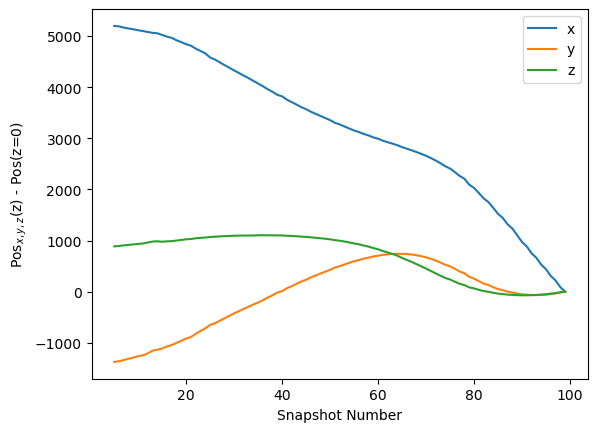

In [7]:
# plot of the evolution of the chosen subhalo's position through time

with h5py.File(mpb,'r') as f:
    pos = f['SubhaloPos'][:]
    snapnum = f['SnapNum'][:] 

for i in range(3):
    plt.plot(snapnum,pos[:,i] - pos[0,i], label=['x','y','z'][i])  # centres on pos(0,0,0) at z=0
plt.legend()
plt.xlabel('Snapshot Number')
plt.ylabel('Pos$_{x,y,z}$(z) - Pos(z=0)');

In [ ]:
# plot of mass weighted gas density around a subhalo 

subhalo_url = 'http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/17185/'  # subhalo with ID [second num] in snapshot [first num]
single_subhalo = get(subhalo_url)
cutout = get(subhalo_url+'cutout.hdf5', {'gas':'Coordinates,Masses'})  # gas = PartType0, star = PartType4

with h5py.File(cutout,'r') as f:
    x = f['PartType0']['Coordinates'][:,0] - single_subhalo['pos_x']
    y = f['PartType0']['Coordinates'][:,1] - single_subhalo['pos_y']
    density = np.log10(f['PartType0']['Masses'][:])  # stellar distribution weighted by the log of stellar cell mass
plt.hist2d(x, y, weights=density, bins=[150,150])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]');

In [ ]:
# plotting galactic properties through time

fields = ['snap', 'id', 'mass_gas', 'mass_stars', 'starmetallicitymaxrad', 'gasmetallicitysfrweighted', 'sfrinmaxrad']
r = {}  # make empty dictionary of data types
for field in fields:
    r[field] = []
    
subhalo = get('http://www.tng-project.org/api/TNG100-1/snapshots/0/subhalos/0/')  # change snapshot numbers below if changing snapshot here
while subhalo['desc_sfid'] != -1:  # desc_sfid = -1 indicates that this subhalo has no descendent in the SubLink trees
    for field in fields:
        r[field].append(subhalo[field])
    subhalo = get(subhalo['related']['sublink_descendant'])  # descendent subhalo information
    
mass_logmsun_gas = np.log10(np.array(r['mass_gas'])*1e10/0.704)
mass_logmsun_star = np.log10(np.array(r['mass_stars'])*1e10/0.704)

# convert snapshot number to redshift
snapshots = np.linspace(1, 100, 99, endpoint=False).tolist()
redshifts = []
for snap in snapshots:
    redshifts.append(il.groupcat.loadHeader('./sims.TNG/TNG100-1/output/', snap)['Redshift'])
redshifts = redshifts[:-1]
redshifts.append(int(0))

figure, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(redshifts, mass_logmsun_gas, label='Gas Mass')
axis[0].plot(redshifts, mass_logmsun_star, label='Stellar Mass')
axis[0].set_xlabel('Redshift')
axis[0].set_ylabel('Mass [log $M_\odot$]')
axis[0].legend()
axis[1].plot(redshifts, r['starmetallicitymaxrad'], label='Stellar Metallicity')
axis[1].plot(redshifts, r['gasmetallicitysfrweighted'], label='Gas Metallicity (SFR Weighted)')
axis[1].set_xlabel('Redshift')
axis[1].set_ylabel('Metallicity')
axis[1].legend()
axis[2].plot(redshifts, r['sfrinmaxrad'], label='SFR')
axis[2].set_xlabel('Redshift')
axis[2].set_ylabel('Star Formation Rate')
axis[2].legend()